In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from keras.models import load_model
import numpy as np

In [ ]:
import tensorflow as tf

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError: # If TPU not found
  tpu = None

# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
else:
  tpu_strategy = tf.distribute.get_strategy() # Default strategy that works on CPU and single GPU
  print('Running on CPU instead')
print("Number of accelerators: ", tpu_strategy.num_replicas_in_sync)  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_path = "/content/drive/MyDrive/"

# Load pre-trained isolated model

---weights of model are from ResNet50 pre-trained model



In [ ]:
with tpu_strategy.scope():
    isolated_model = tf.keras.models.load_model(model_path+"Resnet50_isolated_model_30epoch_cifar10.h5")

# Discriminator defintion

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# generator defintion

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim+2))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

# GAN defintion

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# some functions for generating real and fake samples

In [ ]:
# load and prepare cifar10 training images
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (testX, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	X2 = testX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return X, X2
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples, covert_msg):
	# generate points in latent space
	l_points = generate_latent_points(latent_dim, n_samples)
	x_input = np.concatenate([covert_msg, l_points], axis=1)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# some functions for plots

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
 
# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# definition of custom loss

In [ ]:
BATCH_SIZE_PER_REPLICA = 16
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * tpu_strategy.num_replicas_in_sync
with tpu_strategy.scope():
    # Set reduction to `none` so we can do the reduction afterwards and divide by
    # global batch size.
    mae = tf.keras.losses.MeanAbsoluteError(
          reduction=tf.keras.losses.Reduction.NONE)
    def Covert_customLoss(yTrue,yPred):
        per_example_loss = mae(yTrue,yPred*mask)
        return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)

In [ ]:
def generate_covert_samples(n_samples):
    covert = np.random.randint(2,size=n_samples)
    covert_msg = np.array([[c, int(not(c))] for c  in covert], dtype=np.float32)
    covert_output = np.zeros((covert.shape[0], output_dim))
    for i in range(covert.shape[0]):
      if (covert[i]==0):
        covert_output[i][TARGET_INDEX1]=600
      if (covert[i]==1):
        covert_output[i][TARGET_INDEX2]=600
    return covert_msg, covert_output

# Covert model definition

In [ ]:
from tensorflow.keras.optimizers import Adam

def define_covert_model(i_model, g_model):
    i_model.trainable = False
    intermediate_layer_model = tf.keras.Model(inputs=i_model.input,
                                       outputs=i_model.get_layer(index=-2).output)

    c_model = Sequential()
    c_model.add(g_model)
    c_model.add(intermediate_layer_model)
    opt = Adam(learning_rate=0.0001)
    c_model.compile(loss=Covert_customLoss,
                    optimizer=opt)
    return c_model

# a function for discriminator evaluation, plot generated images, save generator model

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	covert = np.random.randint(2,size=n_samples)
	covert_msg = np.array([[c, int(not(c))] for c  in covert], dtype=np.float32)
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples, covert_msg)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

In [ ]:
def save_function(epoch):
	filename = "covert_generator_model_%03d.h5" % (epoch+1)
	g_model.save(model_path + filename)

In [ ]:
def train_covert_model(_size):
  c_msg, c_out = generate_covert_samples(_size)
  l_points = generate_latent_points(latent_dim, _size)
  c_l = np.concatenate([c_msg, l_points], axis=1)   
  c_loss = c_model.fit(c_l,c_out,batch_size=32)
  return c_loss

In [ ]:
def show_GAN_images(epoch, n_batch):
  # load model
  filename = "covert_generator_model_%03d.h5" % (epoch+1)
  model = load_model(model_path + filename)
  # generate images
  latent_points = generate_latent_points(latent_dim, n_batch)
  c_msg, c_out = generate_covert_samples(n_batch)
  c_l = np.concatenate([c_msg, latent_points], axis=1)
  # generate images
  X = model.predict(c_l)
  # scale from [-1,1] to [0,1]
  X = (X + 1) / 2.0
  # plot the result
  create_plot(X, 10)

In [ ]:
def show_covert_indexes(c_model):
  c_msg, c_out = generate_covert_samples(20)
  l_points = generate_latent_points(latent_dim, 20)
  c_l = np.concatenate([c_msg, l_points], axis=1)
  covert_out = c_model.predict(c_l)
  for k in range(20):
    print(c_msg[k], "   ",
          covert_out[k][TARGET_INDEX1], "   ",
          covert_out[k][TARGET_INDEX2], "   ",
          )

In [ ]:
from sklearn.metrics import confusion_matrix

def show_indicator(c_model):
  c_msg, c_out = generate_covert_samples(1000)
  l_points = generate_latent_points(latent_dim, 1000)
  c_l = np.concatenate([c_msg, l_points], axis=1)
  covert_out = c_model.predict(c_l)

  y_true, y_pred = indicator(c_msg, covert_out)
  print(confusion_matrix(y_true, y_pred))

# define global parameters and load dataset

In [ ]:
# load image data
dataset, testData = load_real_samples()

im_model = tf.keras.Model(inputs=isolated_model.input,
                                       outputs=isolated_model.get_layer(index=-2).output)
o=im_model(dataset)
output_dim = o.shape[1]

TARGET_INDEX1 = 0
TARGET_INDEX2 = 1
mask = np.zeros(output_dim)
mask[TARGET_INDEX1] = 1
mask[TARGET_INDEX2] = 1

# define indicator function

In [ ]:
def indicator(c_msg, real_outputs):
  _size = c_msg.shape[0]
  y_pred=[None]*_size
  y_true=[None]*_size
  for i in range(_size):

    if(all(c_msg[i]==[0,1])):
      y_true[i]=0
    elif(all(c_msg[i]==[1,0])):
      y_true[i]=1
    else:
      y_true[i]=2

    ro1=real_outputs[i][TARGET_INDEX1]
    ro2=real_outputs[i][TARGET_INDEX2]
    if (abs(ro1)>5 and abs(ro2)<0.5):
      y_pred[i]=0
    elif (abs(ro1)<0.5 and abs(ro2)>5):
      y_pred[i]=1
    else:
      y_pred[i]=2
      
  return y_true,y_pred

# define models and train models

In [ ]:
with tpu_strategy.scope():
  # size of the latent space
  latent_dim = 10
  # create the discriminator
  d_model = define_discriminator()
  # create the generator
  g_model = define_generator(latent_dim)
  # create the gan
  gan_model = define_gan(g_model, d_model)

  c_model = define_covert_model(isolated_model, g_model)

  # train model
  train(c_model, g_model, d_model, gan_model, dataset, latent_dim)

load models that are good for coverting signal 0 and 1

In [ ]:
with tpu_strategy.scope():
  # size of the latent space
  latent_dim = 10
  d_model0 = define_discriminator()
  model_path = "/content/drive/MyDrive/covert_generator/"
  filename = "covert_generator_model_057.h5"
  g_model0 = load_model(model_path + filename)
  gan_model0 = define_gan(g_model0, d_model0)

  c_model0 = define_covert_model(isolated_model, g_model0)

In [ ]:
with tpu_strategy.scope():
  # size of the latent space
  latent_dim = 10
  d_model1 = define_discriminator()
  model_path = "/content/drive/MyDrive/covert_generator/"
  filename = "covert_generator7_model_049.h5"
  g_model1 = load_model(model_path + filename)
  gan_model1 = define_gan(g_model1, d_model1)

  c_model1 = define_covert_model(isolated_model, g_model1)

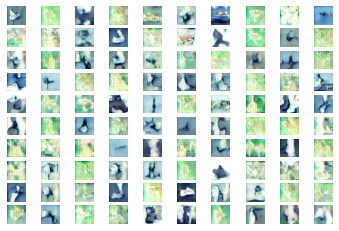

[0. 1.]     3.164246     0.0    
[1. 0.]     0.8610059     1.218859    
[0. 1.]     19.454157     0.0    
[1. 0.]     0.0     10.592658    
[0. 1.]     17.093649     0.0    
[1. 0.]     1.373416     0.0    
[1. 0.]     0.0     1.4897811    
[0. 1.]     0.0     0.0    
[1. 0.]     0.0     1.9367883    
[1. 0.]     0.0     0.0    
[0. 1.]     13.251297     0.16474712    
[1. 0.]     0.0     6.4475493    
[1. 0.]     0.0     7.36162    
[1. 0.]     0.0     0.0    
[0. 1.]     28.510412     0.0    
[1. 0.]     0.0     3.5369997    
[1. 0.]     0.60541576     3.7574751    
[0. 1.]     1.9470385     0.0    
[1. 0.]     0.0     0.5797682    
[0. 1.]     10.039542     0.0    
[[396   0  85]
 [  1 147 371]
 [  0   0   0]]


In [ ]:
latent_points = generate_latent_points(latent_dim, 1000)
c_msg, c_out = generate_covert_samples(1000)
c_l = np.concatenate([c_msg, latent_points], axis=1)
# generate images
X = g_model0.predict(c_l)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)

show_covert_indexes(c_model0)
show_indicator(c_model0)

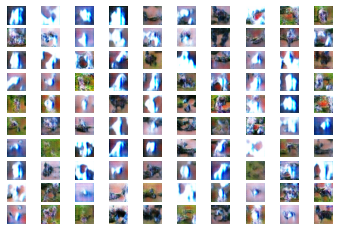

[1. 0.]     0.0     15.4380455    
[0. 1.]     0.0     0.0    
[0. 1.]     0.0     0.041903496    
[0. 1.]     0.0     0.0    
[0. 1.]     0.0     0.79712725    
[0. 1.]     0.0     0.0    
[0. 1.]     0.0     0.0    
[0. 1.]     0.0     0.0    
[1. 0.]     0.18712056     16.75932    
[1. 0.]     0.0     18.185312    
[0. 1.]     0.0     0.0    
[0. 1.]     0.0     0.0    
[1. 0.]     3.3418417     14.804155    
[1. 0.]     0.0     21.978107    
[1. 0.]     0.0     20.64883    
[1. 0.]     0.0     19.479273    
[0. 1.]     0.0     0.0    
[1. 0.]     0.0     20.044691    
[0. 1.]     0.0     0.0    
[0. 1.]     0.0     0.0    
[[  0   0 510]
 [  0 414  76]
 [  0   0   0]]


In [ ]:
latent_points = generate_latent_points(latent_dim, 1000)
c_msg, c_out = generate_covert_samples(1000)
c_l = np.concatenate([c_msg, latent_points], axis=1)
# generate images
X = g_model1.predict(c_l)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)

show_covert_indexes(c_model1)
show_indicator(c_model1)

In [ ]:
c0 = np.array([[0, 1] for i  in range(500)], dtype=np.float32)
c1 = np.array([[1, 0] for i  in range(500)], dtype=np.float32)

latent_points = generate_latent_points(latent_dim, 1000)
c_l0 = np.concatenate([c0, latent_points[:500]], axis=1)
c_l1 = np.concatenate([c1, latent_points[500:]], axis=1)

X0 = g_model0.predict(c_l0)
X1 = g_model1.predict(c_l1)

out0=im_model.predict(X0)
out1=im_model.predict(X1)

In [ ]:
y_true0, y_pred0 = indicator(c0, out0)
y_true1, y_pred1 = indicator(c1, out1)

y_true = [*y_true0, *y_true1]
y_pred = [*y_pred0, *y_pred1]
print(confusion_matrix(y_true, y_pred))

[[421   0  79]
 [  0 414  86]
 [  0   0   0]]


In [ ]:
cm = confusion_matrix(y_true, y_pred)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(accuracy_score(y_true0, y_pred0))
print(precision_score(y_true0, y_pred0, average='macro'))
print(recall_score(y_true0, y_pred0, average='macro'))
print(f1_score(y_true0, y_pred0, average='macro'))

0.842
0.5
0.421
0.4571118349619978


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(accuracy_score(y_true1, y_pred1))
print(precision_score(y_true1, y_pred1, average='macro'))
print(recall_score(y_true1, y_pred1, average='macro'))
print(f1_score(y_true1, y_pred1, average='macro'))

0.828
0.5
0.414
0.45295404814004375


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(accuracy_score(y_true, y_pred))
print(precision_score(y_true, y_pred, average='macro'))
print(recall_score(y_true, y_pred, average='macro'))
print(f1_score(y_true, y_pred, average='macro'))

0.835
0.6666666666666666
0.5566666666666666
0.6067105887346944


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def bit_error_rate(y_true, y_pred):
  acc = accuracy_score(y_true, y_pred)
  ber = 1 - acc
  return ber

In [ ]:
ber  = bit_error_rate(y_true, y_pred)
ber0 = bit_error_rate(y_true0, y_pred0)
ber1 = bit_error_rate(y_true1, y_pred1)

print(ber0, ber1, ber)

0.15800000000000003 0.17200000000000004 0.16500000000000004


In [ ]:
noise_images = testData[:1000]
noise_pre_last_layer=im_model.predict(noise_images)

c_noise = np.array([[1, 1] for i  in range(1000)], dtype=np.float32)

y_true_noise, y_pred_noise = indicator(c_noise, noise_pre_last_layer)
print(confusion_matrix(y_true_noise, y_pred_noise))

[[  0   0   0]
 [  0   0   0]
 [  1   4 995]]


In [ ]:
for i in range(1000):
  if(noise_pre_last_layer[i][0]>5):
    print(i, noise_pre_last_layer[i])

917 [6.457012  0.        0.        ... 0.        1.5602422 4.5667944]
